In [1]:
import pickle
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy as sc
from statistics import median, mean, stdev, mode
from scipy.signal import find_peaks, peak_prominences, peak_widths
import scipy.integrate as integrate
import scipy.special as special
import seaborn as sns
import os
sns.set_context('talk')

In [2]:
def flatten(lst):
    """Flatten a nested list."""
    flat_list = []
    for item in lst:
        if isinstance(item, list):
            flat_list.extend(flatten(item))
        else:
            flat_list.append(item)
    return flat_list


In [72]:
path = os.getcwd() + '/PID/20241017/'
filename = '5perc_EV_20cm_pump_low_gain_5_0.h5'
filepath = path + filename
print(filepath)
dfile = h5py.File(filepath,'r')
print(dfile['measurement'].keys())
data = dfile['measurement/background_odor_task/buffer'][:] #load data buffer to numpy arrray
stat = dfile['measurement/background_odor_task/stat'][:] #load task statistics
side_stat = dfile['measurement/background_odor_task/side_stat'][:]  #load task statistics with side information
settings = dfile['measurement/background_odor_task/settings'].attrs

/Users/boero/OEA_Data_Analysis/PID/20241017/5perc_EV_20cm_pump_low_gain_5_0.h5
<KeysViewHDF5 ['background_odor_task']>


In [55]:
from pid_functions import*

In [13]:
for i in range(data.shape[1]):
    print(data[:,i].max(),data[:,i].std())

1.2498988181494715 0.2833857890746658
0.0 0.0
0.0 0.0
0.04294419431789172 0.003810637631885515
0.0 0.0
0.0 0.0
100.0 4.708804466759352
100.0 49.689902394752195
0.0 0.0
0.0 0.0
94.0 46.99999981432099
0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0
17000.0 5151.256287290775
0.0 0.0


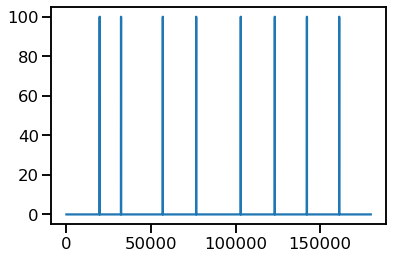

In [15]:
plt.plot(data[:,6])

9
11000


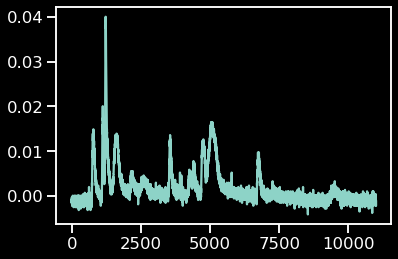

In [73]:
# Load raw data into numpy array
#breath = 0
lick0 = 1
lick1 = 2
PID_index = 3 # index number for PID signal
cl_air = 6 + 4 #index number of clean air channel in h5file
#odor_0 = 6 + 0
odor_1 = 6 + 1 #index number of odor channel 1 in h5file
#odor_2 = 6 + settings['channel2'] #index number of odor channel 2 in h5file
end_time = len(data) # in milisecond
delay_time = settings['delay'] #ms, delay time of the task
go_time = settings['go'] #ms, go time of the task
refract_time = settings['refract'] #ms, refraction period time of the task
pulse_time = 50
ntrials = np.argwhere(np.diff(data[:,cl_air]) == -94).shape[0]

PID_signal = data[0:end_time,PID_index]
filt_signal = bp_filter(PID_signal-np.median(PID_signal))
odor_profile_1 = data[0:end_time,odor_1]

print(ntrials)

total_time = delay_time + go_time #ms, the total time that we are analyzing for each trial
print(total_time)
onset = np.argwhere(np.diff(data[:,cl_air]) == -94).reshape(ntrials,1) #find out hte onset of each trial
interval = np.arange(total_time).reshape(1,total_time) #define a interval to extract for each trial
refract_interval = np.arange(refract_time)[::-1].reshape(1,refract_time) # define a interval for pretrial, flipped
trial_inds = onset + interval #get the indices for all the wanted data for all trials
pre_inds = onset - refract_interval #get the indices for all the wanted data in all pre-trials

# get all the trial informations
trial_odor = data[:,odor_1][trial_inds[:-1,:]]
PID = PID_signal[trial_inds[:-1,:]]
PID_filt = filt_signal[trial_inds[:-1,:]]

#Assigning identity to the different channels 

plt.plot(PID[0])

In [28]:
import scipy.io
data = {'PID_data': PID, 'distance': '15cm', 'odor': 'EV 5%'}
scipy.io.savemat('PID_data.mat', data)

0


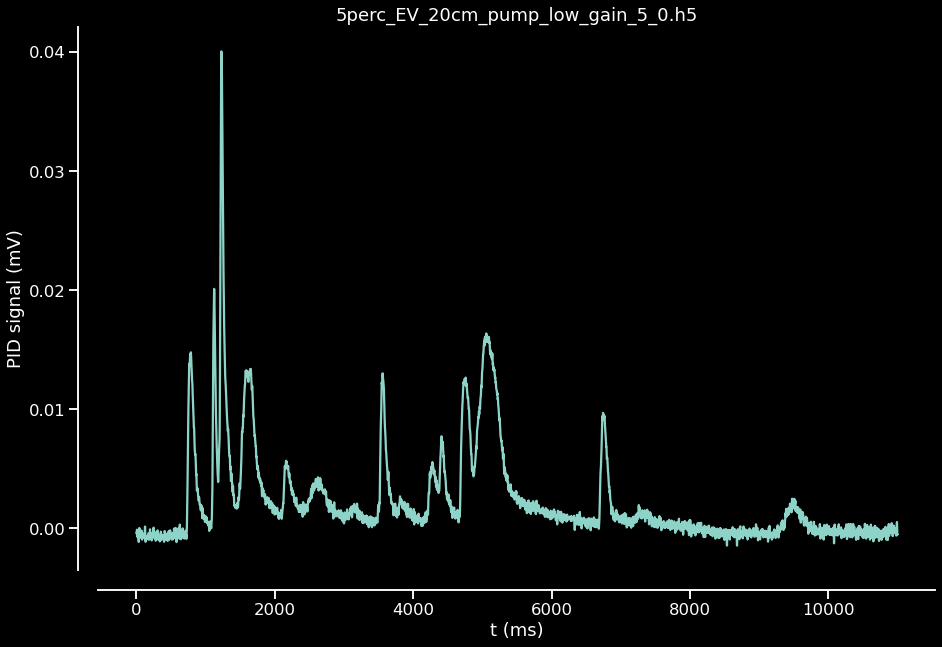

1


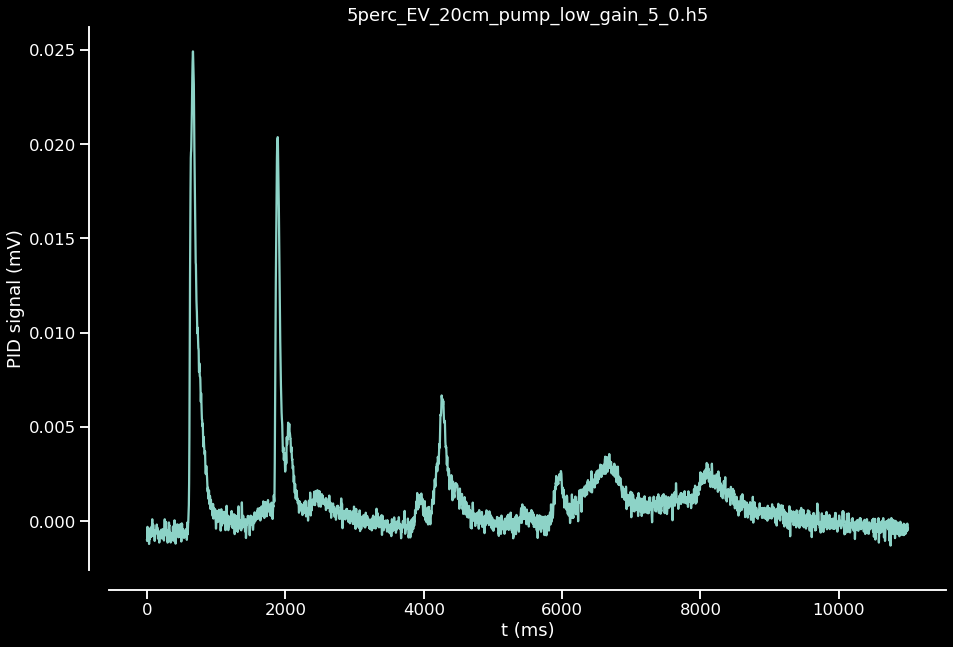

2


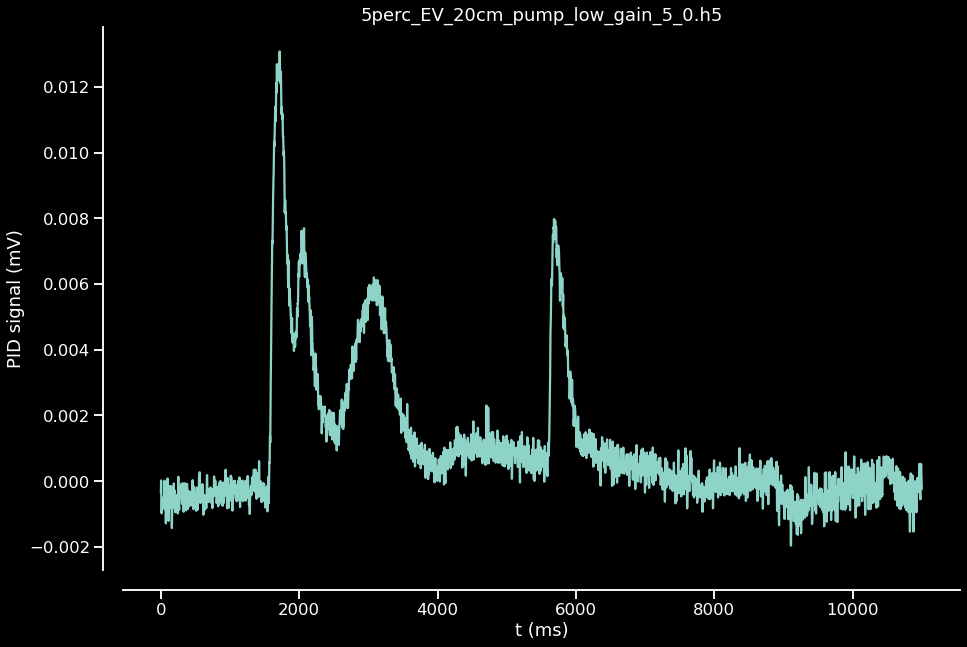

3


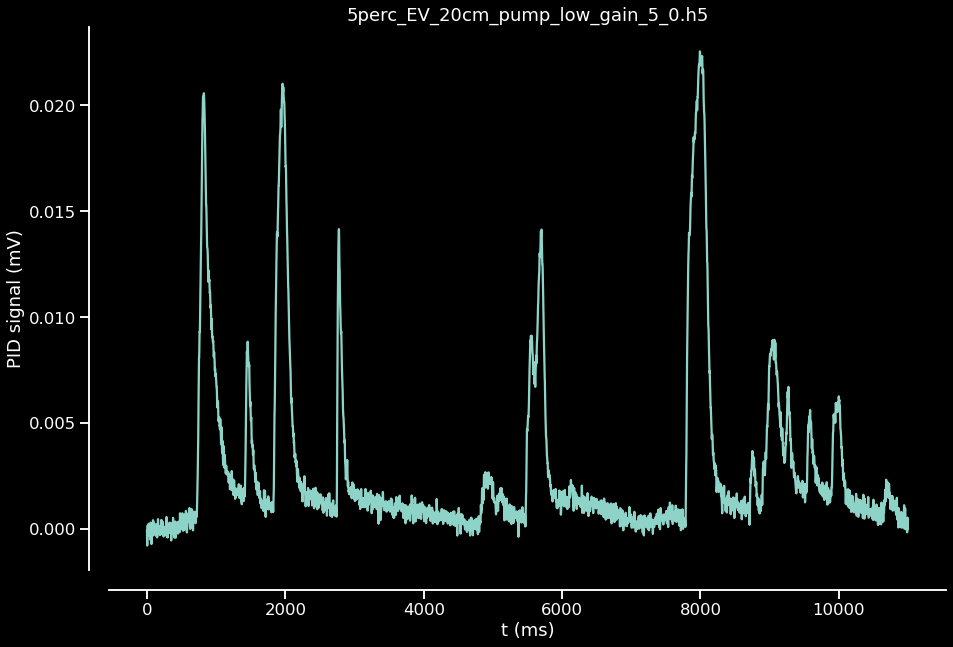

4


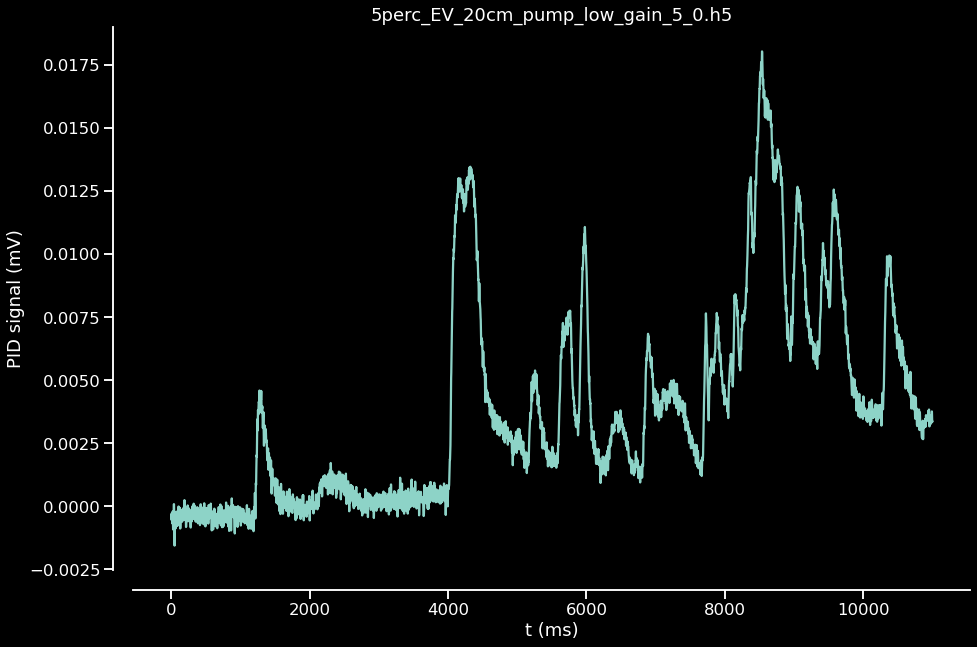

5


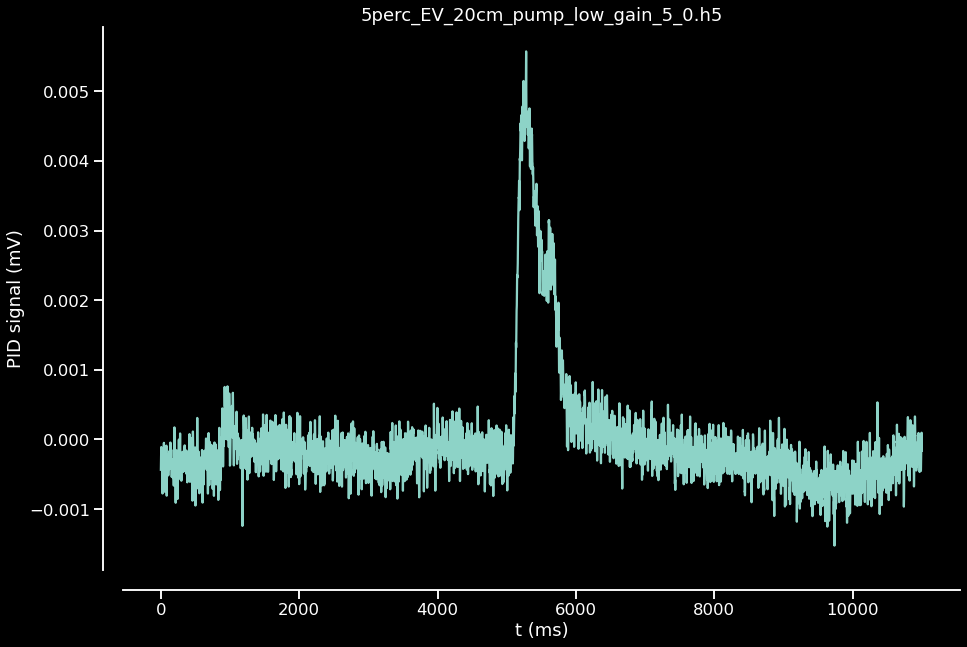

6


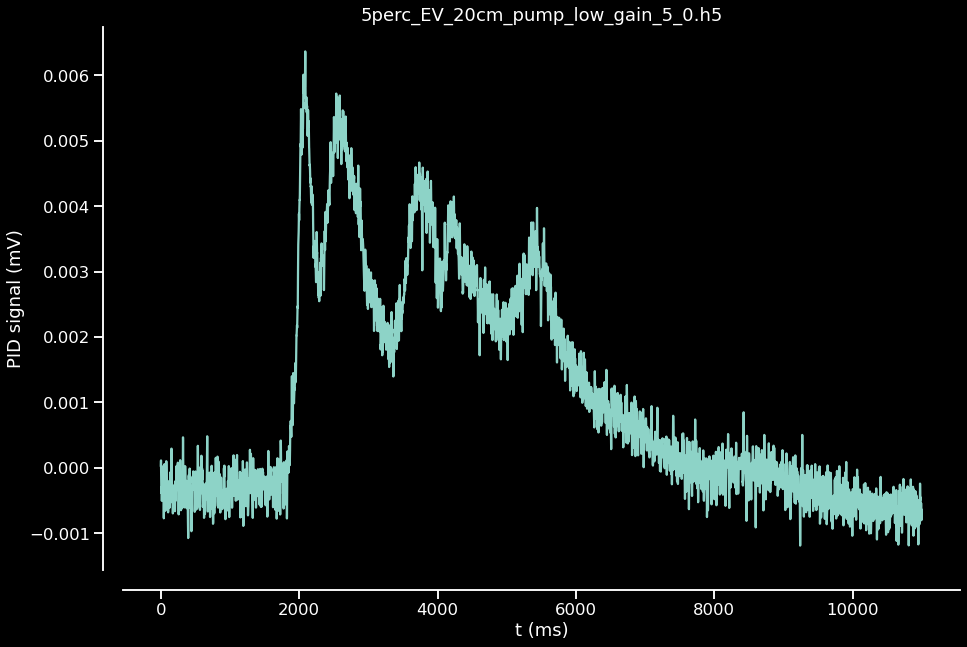

7


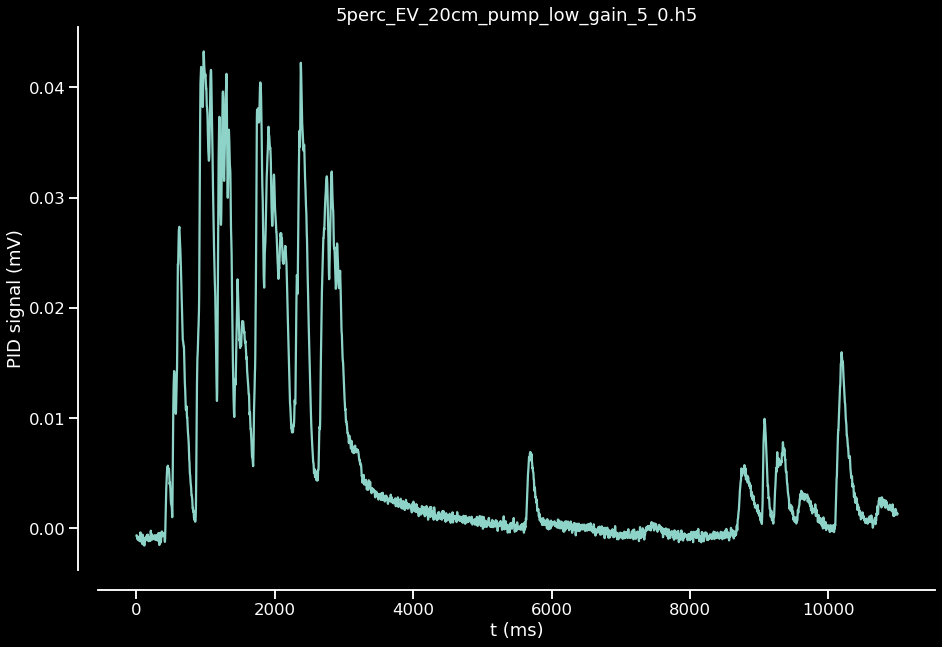

In [74]:
for i in range(len(PID)):
    print(i)
    plt.figure(figsize=(15,10))
    plt.plot(PID_filt[i], clip_on=True)
    #plt.plot(trial_odor[i]*0.0002, clip_on=True)
    plt.xlabel('t (ms)')
    plt.ylabel('PID signal (mV)')
    #plt.ylim(-0.01,0.05)
    #plt.xticks(np.arange(0,11000,2000))
    sns.despine(offset=20)
    plt.title(filename)
    #plt.xlim(0,2100)
    plt.style.use('dark_background')
    
    plt.show()

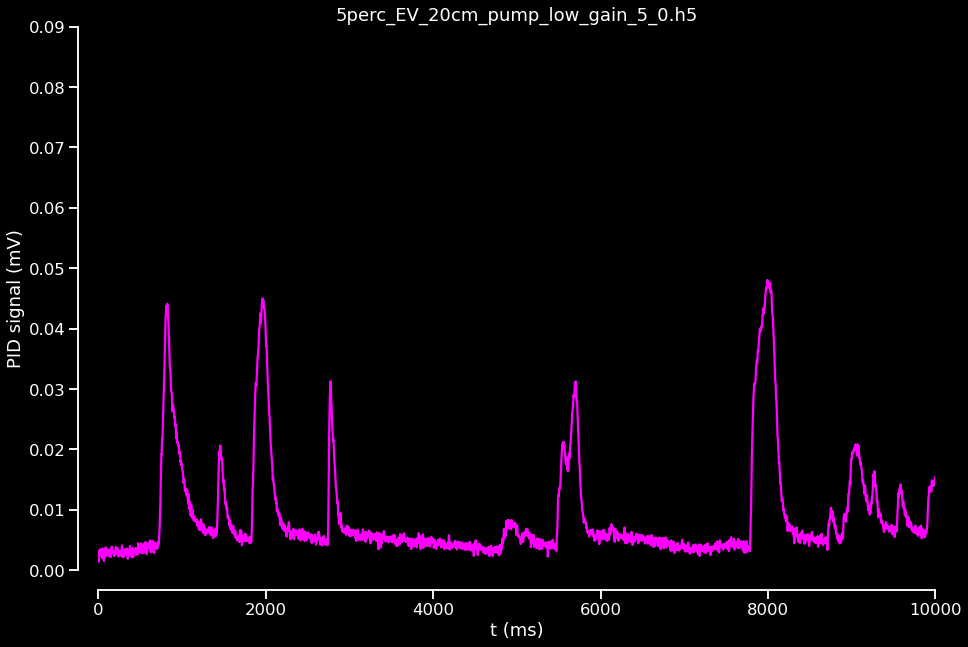

In [79]:
plt.figure(figsize=(15,10))
plt.plot(PID_filt[3]*2+0.003, clip_on=True, color='magenta')
plt.xlabel('t (ms)')
plt.ylabel('PID signal (mV)')
plt.ylim(0,0.09)
plt.xlim(0,10000)
#plt.xticks(np.arange(0,11000,2000))
sns.despine(offset=20)
plt.title(filename)
#plt.xlim(0,2100)
plt.style.use('dark_background')
plt.savefig('PID_profile_20_cm.svg', format='svg', transparent='true', bbox_inches='tight')

plt.show()

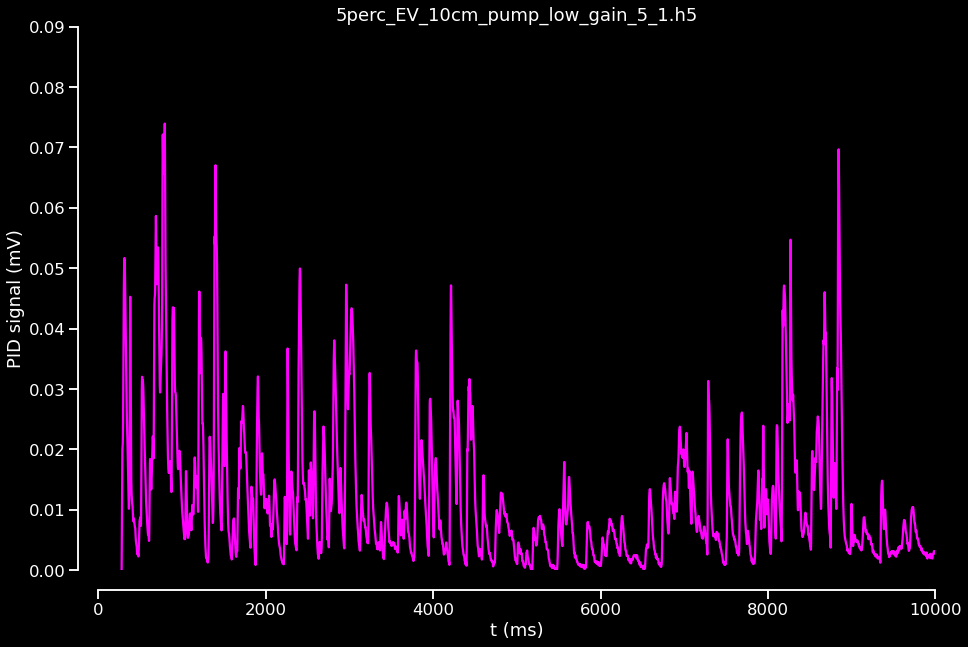

In [51]:
plt.figure(figsize=(15,10))
plt.plot(PID_filt[2]+0.002, clip_on=True, color='magenta')
plt.xlabel('t (ms)')
plt.ylabel('PID signal (mV)')
plt.ylim(0,0.09)
plt.xlim(0,10000)
#plt.xticks(np.arange(0,11000,2000))
sns.despine(offset=20)
plt.title(filename)
#plt.xlim(0,2100)
plt.style.use('dark_background')
plt.savefig('PID_profile_10_cm.svg', format='svg', transparent='true', bbox_inches='tight')

plt.show()

In [175]:
def PID_peaks(signal, time=None, lower_percent=0.1, upper_percent=0.9):
    rise_time = list()
    #halfwidths = list()

    # Step 1: Find peaks in the signal
    peaks, _ = find_peaks(signal, height=0.003, width=10)
    #print(len(peaks))

    if len(peaks) == 0:
        raise ValueError("No peaks found in the signal.")
    
    results_half = peak_widths(signal, peaks, rel_height=0.5)
    #halfwidths.append(results_half[0].tolist())
        
    # for p in range(len(peaks)):# Step 2: For each peak, calculate the rise time
    #     peak_idx = peaks[p]  # Using the first peak for simplicity
    #     #print(peak_idx)
    #     max_value = signal[peak_idx]
        
    #     # Calculate the 10% and 90% thresholds
    #     lower_threshold = lower_percent * max_value
    #     upper_threshold = upper_percent * max_value  
    
    #     lower_crossings = np.where(signal[peak_idx-60:peak_idx] >= lower_threshold)[0]
    #     upper_crossings = np.where(signal[peak_idx-60:peak_idx] >= upper_threshold)[0]

    #     if len(lower_crossings) == 0 or len(upper_crossings) == 0:
    #         raise ValueError("The signal does not cross the specified thresholds.")
        
    #     first_lower_crossing = lower_crossings[0]
    #     first_upper_crossing = upper_crossings[0]
        
    #     # Step 4: Calculate rise time
    #     if time is not None:
    #         rt = time[first_upper_crossing] - time[first_lower_crossing]
    #     else:
    #         rt = first_upper_crossing - first_lower_crossing  # Assuming indices represent time units    

    #     rise_time.append(rt)
    
    return results_half[0].tolist()#, rise_time

def PID_analyzer(signal):

    halfwidths = []
    # rise_times = []

    for i in range(19,20):
        #plt.plot(PID_)
        PID_ = signal[i].flatten()
        plt.plot(PID_)
        hw = PID_peaks(PID_, time=None, lower_percent=0.1, upper_percent=0.9)
        print(hw)
        halfwidths.append(hw)
        # rise_times.append(rts)

    # rise_times = [item for sublist in rise_times for item in sublist]
    halfwidths = [item for sublist in halfwidths for item in sublist]

    return halfwidths#, rise_times

In [425]:
def height_threshold(signal, n_sigma):
    return np.median(signal[:8000])+np.std(signal)*n_sigma

def peak_blank_analyzer(datax, threshold):
    
    peaks, _ = find_peaks(datax, height=threshold, distance=15, width=15)
    plt.figure(figsize=(15,10))

    whiff_widths = []
    whiff_segments = []
    blank_indexes = []
    blank_durations = []
    rise_times = []

    # Loop through each peak and find where the signal crosses the threshold
    for peak in peaks:
        # Find left intersection: where the signal crosses the threshold going up, before the peak
        left_intersections = np.where(np.array(datax[:peak]) < threshold)[0]
        left = left_intersections[-1] if len(left_intersections) > 0 else 0

        rise_times.append(peak-left)
    
        # Find right intersection: where the signal crosses the threshold going down, after the peak
        right_intersections = np.where(np.array(datax[peak:]) < threshold)[0]
        right = right_intersections[0] + peak if len(right_intersections) > 0 else len(datax) - 1

        # Check if the current segment overlaps with the last added one
        if len(whiff_segments) == 0 or (left != whiff_segments[-1][0] or right != whiff_segments[-1][1]):
            width = right - left
            whiff_segments.append((left, right))
            whiff_widths.append(width)

    for i in range(len(whiff_segments) - 1):
        right_of_current = whiff_segments[i][1]
        left_of_next = whiff_segments[i + 1][0]

        # Collect subthreshold data points
        if left_of_next > right_of_current:
            subthreshold_indices = list(range(right_of_current, left_of_next))
            blank_indexes.append(subthreshold_indices)
            blank_durations.append(len(subthreshold_indices))

    # Add subthreshold interval before the first peak if applicable
    if whiff_segments[0][0] > 0:
        subthreshold_indices = list(range(0, whiff_segments[0][0]))
        blank_indexes.append(subthreshold_indices)
        blank_durations.insert(0, len(subthreshold_indices))

    # Add subthreshold interval after the last peak if applicable
    if whiff_segments[-1][1] < len(datax) - 1:
        subthreshold_indices = list(range(whiff_segments[-1][1], len(datax)))
        blank_indexes.append(subthreshold_indices)
        blank_durations.append((len(subthreshold_indices)))


    # Output the unique widths
    print("Unique Widths:", whiff_widths)
    print("Subthreshold Intervals (indices and widths):", blank_durations)

    # Plotting for visualization
    fig = plt.figure(figsize=(10,8))
    plt.plot(datax, label='Data')
    plt.plot(peaks, np.array(datax)[peaks], "x", label='Peaks')
    plt.hlines(threshold, 0, len(datax) - 1, color="gray", linestyle="--", label=f'Height = {threshold}')
    for left, right in whiff_segments:
        plt.hlines(threshold, left, right, color="C2", label='Unique Width' if left == whiff_segments[0][0] else "")
    for indices in blank_indexes:
        plt.plot(indices, [threshold - 0.01] * len(indices), color='red', lw=2, label='Subthreshold' if indices == blank_indexes[0] else "")
    #fig.legend()
    
    return whiff_widths, blank_durations, rise_times, fig


Unique Widths: [51, 88, 28, 595, 257, 377, 207, 322, 60, 201, 2, 115, 32, 120, 53, 2, 2, 16, 20, 22]
Subthreshold Intervals (indices and widths): [227, 21, 16, 95, 10, 60, 22, 60, 21, 2371, 272, 907, 101, 159, 138, 232, 14, 134, 1586, 506, 1478]
Unique Widths: [35, 100, 123, 18, 100, 7, 155, 33, 22, 33, 2, 28, 24, 31, 58, 41, 65, 60, 106, 53, 52, 302, 69, 76]
Subthreshold Intervals (indices and widths): [852, 49, 874, 374, 127, 838, 277, 372, 53, 5, 162, 141, 57, 38, 264, 927, 77, 164, 2, 332, 1163, 7, 1400, 93, 759]
Unique Widths: [140, 212, 51, 2, 144, 141, 68, 4, 20, 68, 104, 96, 27, 153, 701, 2, 2, 137, 53, 16, 40, 22, 136, 58, 70]
Subthreshold Intervals (indices and widths): [2634, 160, 119, 529, 60, 46, 130, 105, 109, 26, 24, 5, 211, 130, 297, 49, 1435, 1263, 236, 80, 36, 25, 10, 79, 735]
Unique Widths: [134, 135, 440, 30, 17, 10, 57, 123, 8, 30, 2, 2, 46, 131, 73, 41, 23, 28, 94, 44, 51, 117, 106]
Subthreshold Intervals (indices and widths): [647, 213, 103, 3000, 300, 297, 389, 

<Figure size 1080x720 with 0 Axes>

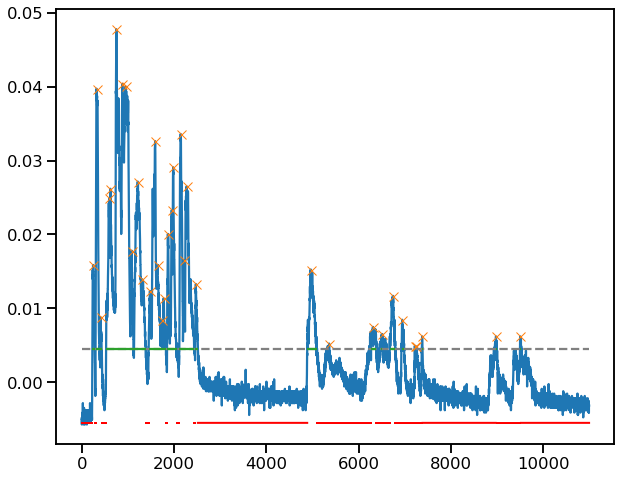

<Figure size 1080x720 with 0 Axes>

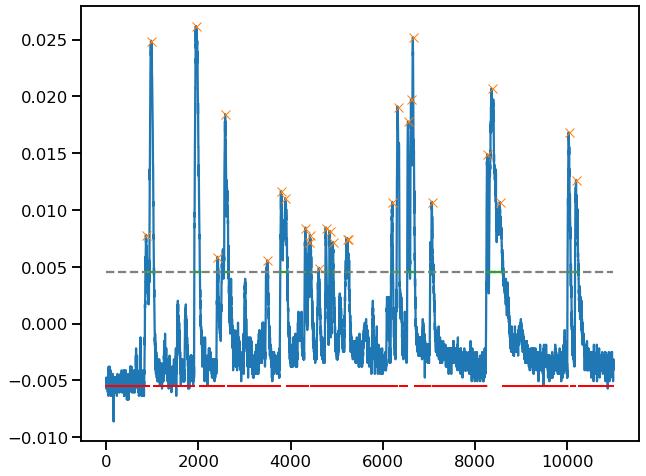

<Figure size 1080x720 with 0 Axes>

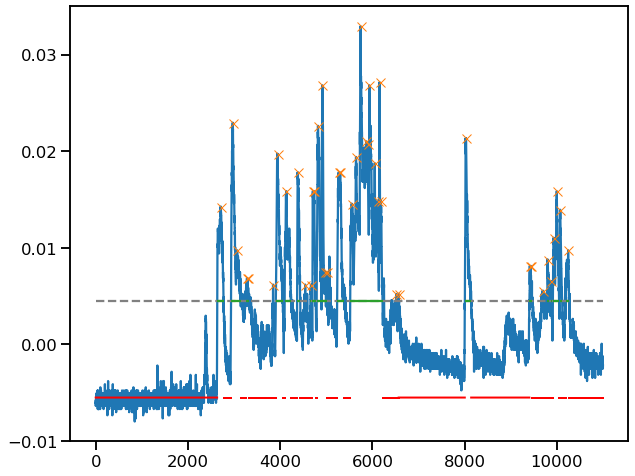

<Figure size 1080x720 with 0 Axes>

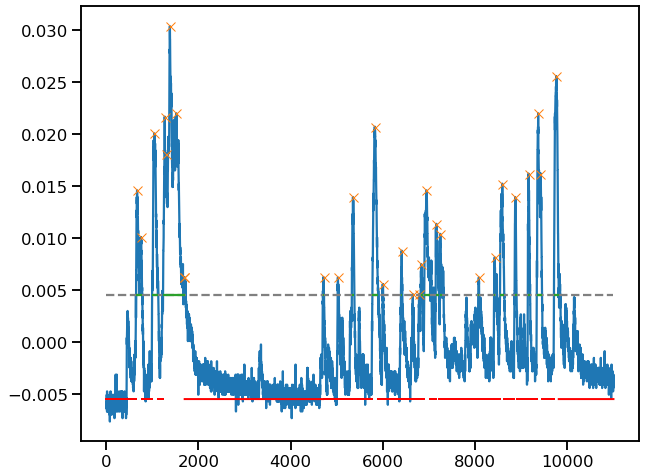

<Figure size 1080x720 with 0 Axes>

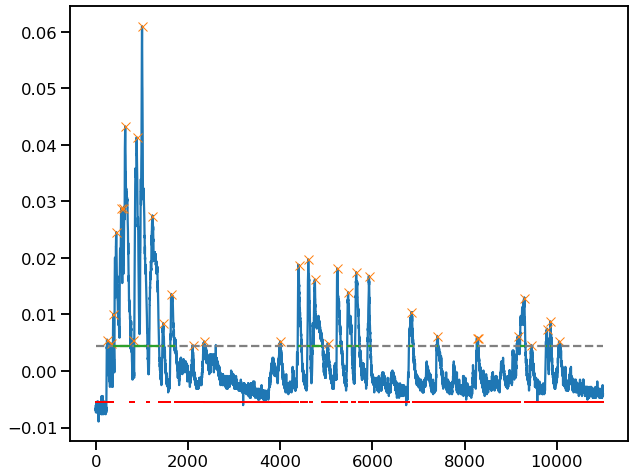

<Figure size 1080x720 with 0 Axes>

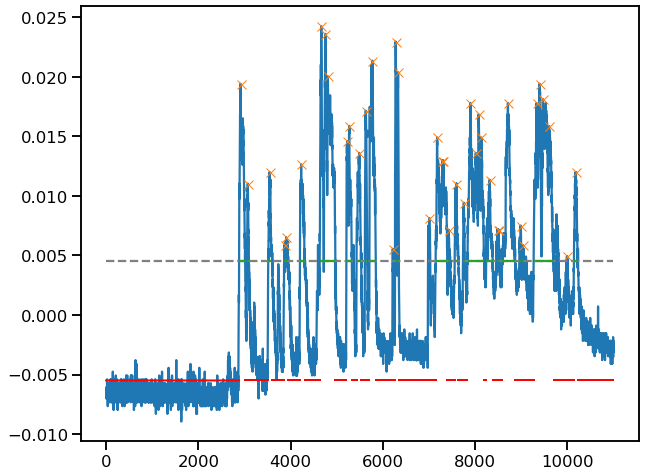

<Figure size 1080x720 with 0 Axes>

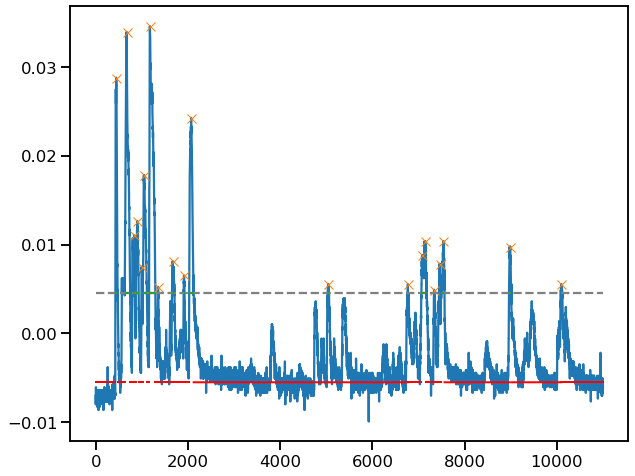

In [378]:
good_trials = [15,19,20,24,26,27,34] #20,
threshold = height_threshold(data[:,3],0.8)
good_blanks = list()
good_whiffs = list()

for trial in good_trials:
    whiffs, blanks, _ =  peak_blank_analyzer(PID[trial],threshold)
    good_whiffs.append(whiffs)
    good_blanks.append(blanks)

good_blanks_list = flatten(good_blanks)
good_whiffs_list = flatten(good_whiffs)




Calculating best minimal value for power law fit
Estimated power-law exponent: 2.7530254320236027
Optimal xmin: 88.0


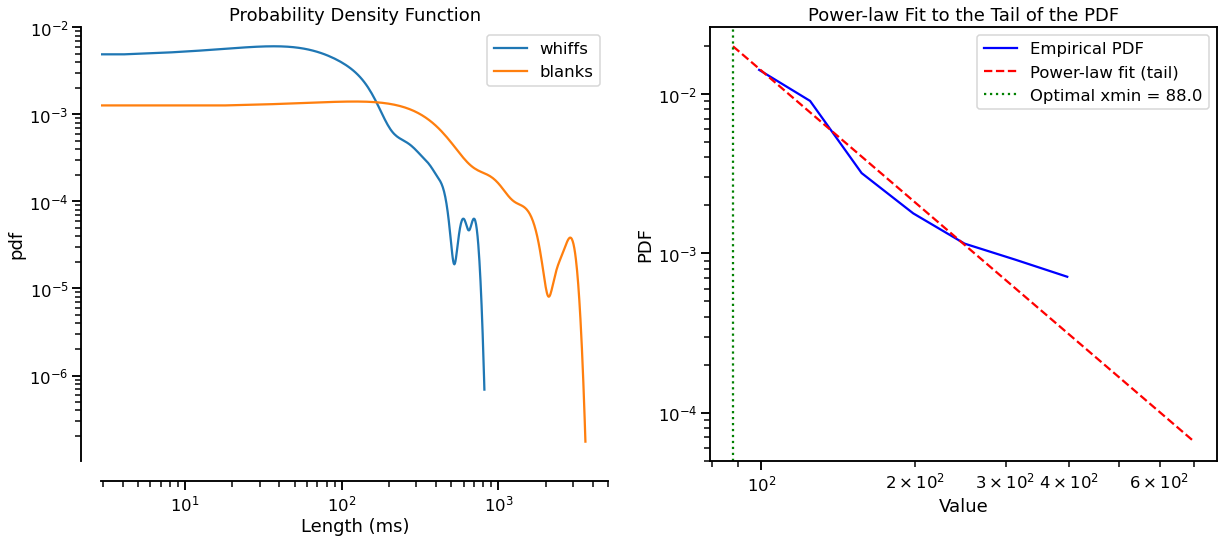

In [424]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)

# Plot using Seaborn's kdeplot
ax = sns.kdeplot(good_whiffs_list, fill=False, clip=(0, np.inf), label='whiffs')
ax = sns.kdeplot(good_blanks_list, fill=False, clip=(0, np.inf), label='blanks')

plt.xlabel('Length (ms)')
plt.ylabel('pdf')
plt.title('Probability Density Function')
plt.yscale('log')
plt.xscale('log')
#plt.axvline(x=0)
plt.legend()
sns.despine(offset=20)

# Retrieve the lines from the plot
lines = ax.get_lines()
kde_data = []

for line in lines:
    x_values = line.get_xdata()
    y_values = line.get_ydata()
    # Filter out negative x_values (if any remain)
    x_values = x_values[x_values > 0]
    y_values = y_values[:len(x_values)]
    kde_data.append((x_values, y_values))

    # Convert the tuples in kde_data to arrays and organize them into a dictionary
kde_arrays = {
    'kde_whiffs_x': np.array(kde_data[0][0]),
    'kde_whiffs_y': np.array(kde_data[0][1]),
    'kde_blanks_x': np.array(kde_data[1][0]),
    'kde_blanks_y': np.array(kde_data[1][1]),
}

# Save the data using scipy.io.savemat
scipy.io.savemat('kde_data.mat', kde_arrays)
np.savetxt('pdf_data.txt', np.column_stack((kde_data[0][0], kde_data[0][1],kde_data[1][0], kde_data[1][1])), header='kde_whiffs_x, kde_whiffs_y, kde_blanks_x, kde_blanks_y', delimiter=',')


# Print the recovered x and y values
# print("Recovered x values:", x_values)
# print("Recovered y values:", y_values)

plt.subplot(1,2,2)

# Fit a power law using the powerlaw package
fit = powerlaw.Fit(good_whiffs_list)

# Extract the exponent and the optimal x_min
alpha = fit.alpha
x_min = fit.xmin
print(f"Estimated power-law exponent: {alpha}")
print(f"Optimal xmin: {x_min}")

# Calculate the empirical PDF using a histogram
hist, bin_edges = np.histogram(good_whiffs_list, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers

# Get the fitted power-law PDF values for the tail
x_fit = np.linspace(x_min, np.max(good_whiffs_list), 100)  # Fitted x values for the power law
y_fit = fit.power_law.pdf(x_fit)  # Corresponding fitted y values

# Save the results to a .mat file
scipy.io.savemat('powerlaw_fit_results.mat', {
    'bin_centers': bin_centers,
    'pdf_values': hist,
    'x_fit': x_fit,
    'y_fit': y_fit,
    'alpha': alpha,
    'x_min': x_min
})

np.savetxt('power_law_fit_data.txt', np.column_stack((x_fit, y_fit)), header='x_fit, y_fit', delimiter=',')
np.savetxt('bin_centers_pdf_values.txt', np.column_stack((bin_centers, hist)), header='bin_centers, pdf_values', delimiter=',')


# Optionally, plot the results
fig = fit.plot_pdf(label='Empirical PDF', color='b')
fit.power_law.plot_pdf(ax=fig, color='r', linestyle='--', label='Power-law fit (tail)')
plt.axvline(x_min, color='g', linestyle=':', label=f'Optimal xmin = {x_min}')
plt.xlabel('Value')
plt.ylabel('PDF')
plt.legend()
plt.title('Power-law Fit to the Tail of the PDF')
plt.show()

# # Fit a power law using the powerlaw package
# fit = powerlaw.Fit(good_whiffs_list)

# # Extract the exponent
# alpha = fit.alpha
# x_min = fit.xmin
# print(f"Estimated power-law exponent: {alpha}")
# print(f"alpha: {alpha}")

# # Plot the fitted power-law distribution
# fig = fit.plot_pdf(label='Empirical PDF', color='b')
# fit.power_law.plot_pdf(ax=fig, color='r', linestyle='--', label='Power-law fit (tail)')
# #plt.axvline(x_min, color='g', linestyle=':', label=f'Optimal xmin = {x_min}')
# plt.text(100,0.0001,f"alpha: {np.round(alpha,3)}")
# plt.xlabel('Length (ms)')
# plt.ylabel('pdf')
# plt.legend()
# sns.despine(offset=20)

# plt.title('Power-law Fit to tail of whiffs PDF')

# plt.show()


In [372]:
pip install powerlaw


Note: you may need to restart the kernel to use updated packages.


Calculating best minimal value for power law fit
Estimated power-law exponent: 2.7530254320236027
alpha: 2.7530254320236027


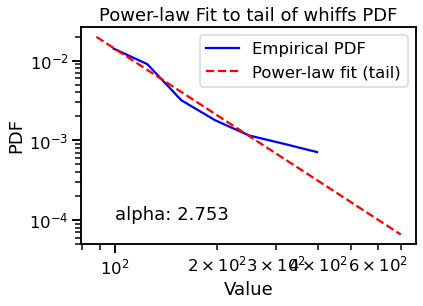

In [387]:

plt.show()


Calculating best minimal value for power law fit
Estimated power-law exponent: 2.9384908971384434
Optimal xmin: 735.0


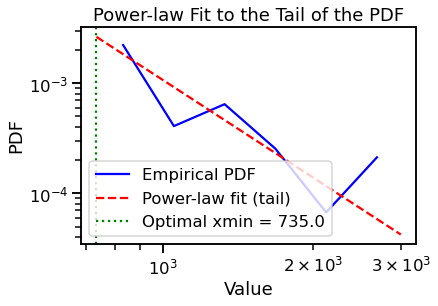

In [382]:
fit = powerlaw.Fit(good_blanks_list)

# Extract the exponent
alpha = fit.alpha
x_min = fit.xmin
print(f"Estimated power-law exponent: {alpha}")
print(f"Optimal xmin: {x_min}")

# Plot the fitted power-law distribution
fig = fit.plot_pdf(label='Empirical PDF', color='b')
fit.power_law.plot_pdf(ax=fig, color='r', linestyle='--', label='Power-law fit (tail)')
plt.axvline(x_min, color='g', linestyle=':', label=f'Optimal xmin = {x_min}')

plt.xlabel('Value')
plt.ylabel('PDF')
plt.legend()
plt.title('Power-law Fit to the Tail of the PDF')
plt.show()

In [406]:
print(kde_data[0].shape)

AttributeError: 'tuple' object has no attribute 'shape'